Try to replicate generating spectra with observational conditions as done in the notebook: https://github.com/desihub/desisim/blob/master/doc/nb/bgs-redshift-efficiency.ipynb . 

In [1]:
import os
os.environ['DESI_BASIS_TEMPLATES']='/Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3'
import sys
import time
import numpy as np 
from astropy.table import Table
from astropy.table import vstack
from scipy.spatial import cKDTree as KDTree
# --local--
import astropy.time
import astropy.units as u

import desisim.specsim
import desisim.simexp
import desisim.obs
import desisim.io
import desisim.util
import desispec.io
import desispec.io.util
import desimodel.io
import desitarget
from desispec.spectra import Spectra
from desispec.resolution import Resolution

from speclite import filters
from desimodel.io import load_throughput
from desisim.io import empty_metatable
from desisim.io import read_basis_templates
from desisim.templates import BGS
from desisim.scripts.quickspectra import sim_spectra
import desitarget.mock.quicksurvey as mockio
from desitarget.cuts import isBGS_bright, isBGS_faint

In [2]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

read in mock data

In [4]:
simseed = 123
simrand = np.random.RandomState(simseed)

In [5]:
mockfile = '/Volumes/chang_eHDD/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS_r20.6.hdf5'
mockdata = mockio.read_durham_mxxl_hdf5(mockfile, rand=simrand, nside=32, nproc=nproc,
                                        healpixels=[3151,3150,3149,3148])

INFO:quicksurvey.py:1472:read_durham_mxxl_hdf5: Assigning healpix pixels with nside = 32
INFO:quicksurvey.py:1482:read_durham_mxxl_hdf5: Trimmed to 38857 BGSs in healpixels [3151, 3150, 3149, 3148]


In [6]:
mockdata['VDISP'] = np.repeat(100.0, len(mockdata['RA'])) # [km/s]

In [7]:
mockdata


{'BRICKNAME': array([u'3249p165', u'3264p157', u'3265p192', ..., u'3248p160',
        u'3244p165', u'3263p160'], dtype='<U8'),
 'DEC': array([16.40729713, 15.77822304, 19.16472244, ..., 15.89919853,
        16.44275475, 15.99462128]),
 'FILES': ['/Volumes/chang_eHDD/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS_r20.6.hdf5'],
 'FILTERNAME': 'sdss2010-r',
 'MAG': array([19.501293, 20.36178 , 19.635508, ..., 20.49723 , 20.299582,
        19.704567], dtype=float32),
 'MOCKID': array([36929249, 36929507, 36929597, ..., 41560733, 41560748, 41561506]),
 'N_PER_FILE': [41561531],
 'OBJID': array([36929249, 36929507, 36929597, ..., 41560733, 41560748, 41561506]),
 'RA': array([324.83517456, 326.50918579, 326.5640564 , ..., 324.72433472,
        324.43347168, 326.44470215]),
 'SDSS_01gr': array([0.93379325, 0.5965194 , 1.000411  , ..., 0.72762054, 0.9644397 ,
        0.35007194], dtype=float32),
 'SDSS_absmag_r01': array([-20.521458, -20.883106, -21.366608, ..., -21.656393, -21.586203,


(14.5, 19.5)

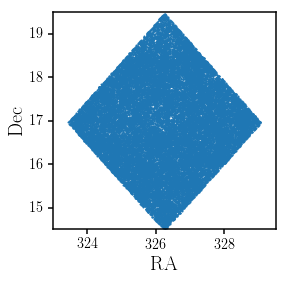

In [8]:
fig = plt.figure(figsize=(4,4)) 
sub = fig.add_subplot(111)
sub.scatter(mockdata['RA'], mockdata['DEC'], s=1)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim([323, 329.5])
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim([14.5, 19.5])

In [9]:
bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)


INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.


In [10]:
for k in bgs_meta.keys():
    print k, bgs_meta[k].data[:5]

TEMPLATEID [0 1 2 3 4]
PASS [304 304 304 304 416]
APER [218 283 281 215 180]
RA [216.56916  216.635505 216.615225 216.524355 216.796665]
DEC [32.642522 32.642946 32.645138 32.645616 32.658003]
Z [0.1334 0.4805 0.1317 0.2033 0.2172]
WEIGHT [1.1542164 1.1542164 1.1515677 1.1542164 2.0422544]
AGES_INFIBER_R [0.5651498  0.6262118  0.46884447 0.40069628 0.9506563 ]
INFIBER_R [0.14169025 0.14382686 0.10343321 0.12284005 0.39181405]
INFIBER_I [0.1508412  0.1507301  0.10864756 0.12593892 0.38240185]
VDISP [179.80457 303.23514 165.      165.      132.96024]
SIGMA_KMS [144.67514 269.76865 206.88818 130.95226  -1.     ]
HBETA [4.9176688e-17 9.2952879e-17 3.2361653e-16 7.8138207e-17 1.1694130e-17]
HBETA_EW [2.2901452 4.054807  4.8051605 2.4020562 0.590293 ]
HBETA_LIMIT [0 0 0 0 1]
HALPHAHBETA [-999. -999. -999. -999. -999.]
OIIIHBETA [-999. -999. -999. -999. -999.]
OIIHBETA [-999. -999. -999. -999. -999.]
NIIHBETA [-999. -999. -999. -999. -999.]
HBETA_CONTINUUM [5.4968196e-12 1.1314922e-11 1.14846

In [11]:
class BGStree(object):
    """Build a KD Tree from BGS template metadata."""
    def __init__(self):
        self.bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)
        self.bgs_tree = KDTree(self._bgs())

    def _bgs(self):
        """Quantities we care about: redshift (z), M_0.1r, and 0.1(g-r).
        """
        zobj = self.bgs_meta['Z'].data
        mabs = self.bgs_meta['SDSS_UGRIZ_ABSMAG_Z01'].data
        rmabs = mabs[:, 2]
        gr = mabs[:, 1] - mabs[:, 2]
        return np.vstack((zobj, rmabs, gr)).T        
    
    def query(self, objtype, matrix, subtype=''):
        """Return the nearest template number based on the KD Tree.

        Args:
          objtype (str): object type
          matrix (numpy.ndarray): (M,N) array (M=number of properties,
            N=number of objects) in the same format as the corresponding
            function for each object type (e.g., self.bgs).
          subtype (str, optional): subtype (only for white dwarfs)

        Returns:
          dist: distance to nearest template
          indx: index of nearest template
        
        """
        if objtype.upper() == 'BGS':
            dist, indx = self.bgs_tree.query(matrix)
        else:
            raise ValueError
                
        return dist, indx

In [12]:

class BGStemplates(object):
    """Generate spectra.  

    """
    def __init__(self, wavemin=1500.0, wavemax=2e4, dw=0.2, 
                 rand=None, verbose=False):
        self.tree = BGStree()
            
        self.wavemin = wavemin
        self.wavemax = wavemax
        self.dw = dw
        self.wave = np.arange(round(wavemin, 1), wavemax, dw)

        self.rand = rand
        self.verbose = verbose

        # Initialize the templates once:
        self.bgs_templates = BGS(wave=self.wave, normfilter='decam2014-r') #normfilter='sdss2010-r') # Need to generalize this!
        self.bgs_templates.normline = None # no emission lines!

    def bgs(self, data, index=None, mockformat='durham_mxxl_hdf5'):
        """Generate spectra for BGS.

        Currently only the MXXL (durham_mxxl_hdf5) mock is supported.  DATA
        needs to have Z, SDSS_absmag_r01, SDSS_01gr, VDISP, and SEED, which are
        assigned in mock.io.read_durham_mxxl_hdf5.  See also BGSKDTree.bgs().

        """
        objtype = 'BGS'
        if index is None:
            index = np.arange(len(data['Z']))
            
        input_meta = empty_metatable(nmodel=len(index), objtype=objtype)
        for inkey, datakey in zip(('SEED', 'MAG', 'REDSHIFT', 'VDISP'),
                                  ('SEED', 'MAG', 'Z', 'VDISP')):
            input_meta[inkey] = data[datakey][index]

        if mockformat.lower() == 'durham_mxxl_hdf5':
            alldata = np.vstack((data['Z'][index],
                                 data['SDSS_absmag_r01'][index],
                                 data['SDSS_01gr'][index])).T
            _, templateid = self.tree.query(objtype, alldata)
        else:
            raise ValueError('Unrecognized mockformat {}!'.format(mockformat))

        input_meta['TEMPLATEID'] = templateid
        flux, _, meta = self.bgs_templates.make_templates(input_meta=input_meta,
                                                          nocolorcuts=True, novdisp=False,
                                                          verbose=self.verbose)

        return flux, meta

In [13]:
# Vary galaxy properties with nominal observing conditions but split 
# the sample into nsim chunks to avoid memory issues.
sim1 = dict(suffix='sim01',
            use_mock=True,
            nsim=10,
            nspec=100,
            seed=11,
           )

In [15]:
reference_conditions = dict(DARK=dict())
reference_conditions['DARK']['SEEING']  = 1.1
reference_conditions['DARK']['EXPTIME'] = 1000
reference_conditions['DARK']['AIRMASS'] = 1.0
reference_conditions['DARK']['MOONFRAC'] = 0.0
reference_conditions['DARK']['MOONALT'] = -60
reference_conditions['DARK']['MOONSEP'] = 180

In [14]:
#from desisim.simexp import reference_conditions
#ref_obsconditions = reference_conditions['BGS']
ref_obsconditions = {'AIRMASS': 1.0, 'EXPTIME': 300, 'SEEING': 1.1, 'MOONALT': -60, 'MOONFRAC': 0.0, 'MOONSEP': 180}
print(ref_obsconditions)

{'SEEING': 1.1, 'AIRMASS': 1.0, 'MOONALT': -60, 'MOONSEP': 180, 'MOONFRAC': 0.0, 'EXPTIME': 300}


In [16]:
def bgs_write_simdata(sim, rand):
    """Build and write a metadata table with the simulation inputs.  
    Currently, the only quantities that can be varied are moonfrac, 
    moonsep, and exptime, but more choices can be added as needed.
    
    """ 
    cols = [
        ('SEED', 'S20'),
        ('NSPEC', 'i4'),
        ('EXPTIME', 'f4'),
        ('AIRMASS', 'f4'),
        ('SEEING', 'f4'),
        ('MOONFRAC', 'f4'),
        ('MOONSEP', 'f4'),
        ('MOONALT', 'f4')]
    simdata = Table(np.zeros(sim['nsim'], dtype=cols))
    
    simdata['EXPTIME'].unit = 's'
    simdata['SEEING'].unit = 'arcsec'
    simdata['MOONSEP'].unit = 'deg'
    simdata['MOONALT'].unit = 'deg'

    simdata['SEED'] = sim['seed']
    simdata['NSPEC'] = sim['nspec']
    simdata['AIRMASS'] = ref_obsconditions['AIRMASS']
    simdata['SEEING'] = ref_obsconditions['SEEING']
    simdata['MOONALT'] = ref_obsconditions['MOONALT']
    
    if 'moonfracmin' in sim.keys():
        simdata['MOONFRAC'] = rand.uniform(sim['moonfracmin'], sim['moonfracmax'], sim['nsim'])
    else:
        simdata['MOONFRAC'] = ref_obsconditions['MOONFRAC']

    if 'moonsepmin' in sim.keys():
        simdata['MOONSEP'] = rand.uniform(sim['moonsepmin'], sim['moonsepmax'], sim['nsim'])
    else:
        simdata['MOONSEP'] = ref_obsconditions['MOONSEP']
        
    if 'exptime' in sim.keys():
        simdata['EXPTIME'] = rand.uniform(sim['exptimemin'], sim['exptimemax'], sim['nsim'])
    else:
        simdata['EXPTIME'] = ref_obsconditions['EXPTIME']
    return simdata

In [17]:
def simdata2obsconditions(simdata):
    obs = dict(AIRMASS=simdata['AIRMASS'], 
               EXPTIME=simdata['EXPTIME'],
               MOONALT=simdata['MOONALT'],
               MOONFRAC=simdata['MOONFRAC'],
               MOONSEP=simdata['MOONSEP'],
               SEEING=simdata['SEEING'])
    return obs

In [18]:
def bgs_make_templates(sim, rand, BGSmaker):
    """Generate the actual templates.  If using the mock data then iterate 
    until we build the desired number of models after applying targeting cuts, 
    otherwise use specified priors on magnitude and redshift.
    
    """
    if sim['use_mock']:
        natatime = np.min( (50, sim['nspec']) )
        ngood = 0
        flux, meta = [], []
        while ngood < sim['nspec']:
            these = rand.choice(len(mockdata['RA']), natatime)
            flux1, meta1 = BGSmaker.bgs(mockdata, index=these)
            
            keep = np.logical_or( isBGS_bright(rflux=meta1['FLUX_R'].data), 
                                 isBGS_faint(rflux=meta1['FLUX_R'].data) )
            ngood1 = np.count_nonzero(keep)
            if ngood1 > 0:
                ngood += ngood1
                flux.append(flux1[keep, :])
                meta.append(meta1[keep])
            
        meta = vstack(meta)[:sim['nspec']]
        flux = np.vstack(flux)[:sim['nspec'], :]
        wave = BGSmaker.wave
        
    else:
        redshift = rand.uniform(sim['zmin'], sim['zmax'], size=sim['nspec'])
        rmag = rand.uniform(sim['rmagmin'], sim['rmagmax'], size=sim['nspec'])

        flux, wave, meta = BGSmaker.bgs_templates.make_templates(
            nmodel=sim['nspec'], redshift=redshift, mag=rmag, seed=sim['seed'])

    return flux, wave, meta

In [50]:
def simSpectra(wave, flux, program, obsconditions=None,
                sourcetype=None, targetid=None, redshift=None, expid=0, seed=0, skyerr=0.0, ra=None, dec=None):
    """
    Simulate spectra from an input set of wavelength and flux and writes a FITS file in the Spectra format that can
    be used as input to the redshift fitter.
    Args:
        wave : 1D np.array of wavelength in Angstrom (in vacuum) in observer frame (i.e. redshifted)
        flux : 1D or 2D np.array. 1D array must have same size as wave, 2D array must have shape[1]=wave.size
               flux has to be in units of 10^-17 ergs/s/cm2/A
        spectra_filename : path to output FITS file in the Spectra format
        program : dark, lrg, qso, gray, grey, elg, bright, mws, bgs
            ignored if obsconditions is not None
    
    Optional:
        obsconditions : dictionnary of observation conditions with SEEING EXPTIME AIRMASS MOONFRAC MOONALT MOONSEP
        sourcetype : list of string, allowed values are (sky,elg,lrg,qso,bgs,star), type of sources, used for fiber aperture loss , default is star
        targetid : list of targetids for each target. default of None has them generated as str(range(nspec))
        redshift : list/array with each index being the redshifts for that target
        expid : this expid number will be saved in the Spectra fibermap
        seed : random seed
        skyerr : fractional sky subtraction error
        ra : numpy array with targets RA (deg)
        dec : numpy array with targets Dec (deg)
    """    
    if len(flux.shape)==1 :
        flux=flux.reshape((1,flux.size))
    nspec=flux.shape[0]
        
    if sourcetype is None :        
        sourcetype = np.array(["star" for i in range(nspec)])
    
    tileid  = 0
    telera  = 0
    teledec = 0    
    dateobs = time.gmtime()
    night   = desisim.obs.get_night(utc=dateobs)
    program = program.lower()
        
       
    frame_fibermap = desispec.io.fibermap.empty_fibermap(nspec)    
    frame_fibermap.meta["FLAVOR"]="custom"
    frame_fibermap.meta["NIGHT"]=night
    frame_fibermap.meta["EXPID"]=expid
    
    # add DESI_TARGET 
    tm = desitarget.targetmask.desi_mask
    frame_fibermap['DESI_TARGET'][sourcetype=="star"]=tm.STD_FSTAR
    frame_fibermap['DESI_TARGET'][sourcetype=="lrg"]=tm.LRG
    frame_fibermap['DESI_TARGET'][sourcetype=="elg"]=tm.ELG
    frame_fibermap['DESI_TARGET'][sourcetype=="qso"]=tm.QSO
    frame_fibermap['DESI_TARGET'][sourcetype=="sky"]=tm.SKY
    frame_fibermap['DESI_TARGET'][sourcetype=="bgs"]=tm.BGS_ANY
    
    if targetid is None:
        targetid = np.arange(nspec).astype(int)
        
    # add TARGETID
    frame_fibermap['TARGETID'] = targetid
         
    # spectra fibermap has two extra fields : night and expid
    # This would be cleaner if desispec would provide the spectra equivalent
    # of desispec.io.empty_fibermap()
    spectra_fibermap = desispec.io.empty_fibermap(nspec)
    spectra_fibermap = desispec.io.util.add_columns(spectra_fibermap,
                       ['NIGHT', 'EXPID', 'TILEID'],
                       [np.int32(night), np.int32(expid), np.int32(tileid)],
                       )
           
    for s in range(nspec):
        for tp in frame_fibermap.dtype.fields:
            spectra_fibermap[s][tp] = frame_fibermap[s][tp]
 
    if ra is not None :
        spectra_fibermap["RA_TARGET"] = ra
        spectra_fibermap["RA_OBS"]    = ra
    if dec is not None :
        spectra_fibermap["DEC_TARGET"] = dec
        spectra_fibermap["DEC_OBS"]    = dec
            
    if obsconditions is None:
        if program in ['dark', 'lrg', 'qso']:
            obsconditions = desisim.simexp.reference_conditions['DARK']
        elif program in ['elg', 'gray', 'grey']:
            obsconditions = desisim.simexp.reference_conditions['GRAY']
        elif program in ['mws', 'bgs', 'bright']:
            obsconditions = desisim.simexp.reference_conditions['BRIGHT']
        else:
            raise ValueError('unknown program {}'.format(program))
    elif isinstance(obsconditions, str):
        try:
            obsconditions = desisim.simexp.reference_conditions[obsconditions.upper()]
        except KeyError:
            raise ValueError('obsconditions {} not in {}'.format(
                obsconditions.upper(),
                list(desisim.simexp.reference_conditions.keys())))
    try:
        params = desimodel.io.load_desiparams()
        wavemin = params['ccd']['b']['wavemin']
        wavemax = params['ccd']['z']['wavemax']
    except KeyError:
        wavemin = desimodel.io.load_throughput('b').wavemin
        wavemax = desimodel.io.load_throughput('z').wavemax

    if wave[0] > wavemin:
        dwave = wave[1] - wave[0]
        npad = int((wave[0] - wavemin)/dwave + 1)
        wavepad = np.arange(npad) * dwave
        wavepad += wave[0] - dwave - wavepad[-1]
        fluxpad = np.zeros((flux.shape[0], len(wavepad)), dtype=flux.dtype)
        wave = np.concatenate([wavepad, wave])
        flux = np.hstack([fluxpad, flux])
        assert flux.shape[1] == len(wave)
        assert np.allclose(dwave, np.diff(wave))
        assert wave[0] <= wavemin

    if wave[-1] < wavemax:
        log.warning('Maximum input wavelength {}<{}; padding with zeros'.format(
                wave[-1], wavemax))
        dwave = wave[-1] - wave[-2]
        npad = int( (wavemax - wave[-1])/dwave + 1 )
        wavepad = wave[-1] + dwave + np.arange(npad)*dwave
        fluxpad = np.zeros((flux.shape[0], len(wavepad)), dtype=flux.dtype)
        wave = np.concatenate([wave, wavepad])
        flux = np.hstack([flux, fluxpad])
        assert flux.shape[1] == len(wave)
        assert np.allclose(dwave, np.diff(wave))
        assert wavemax <= wave[-1]

    ii = (wavemin <= wave) & (wave <= wavemax)

    flux_unit = 1e-17 * u.erg / (u.Angstrom * u.s * u.cm ** 2 )

    wave = wave[ii]*u.Angstrom
    flux = flux[:,ii]*flux_unit

    sim = desisim.simexp.simulate_spectra(wave, flux, fibermap=frame_fibermap,
        obsconditions=obsconditions, redshift=redshift, seed=seed,
        psfconvolve=True)

    random_state = np.random.RandomState(seed)
    sim.generate_random_noise(random_state)

    scale=1e17
    specdata = None

    resolution={}
    for camera in sim.instrument.cameras:
        R = Resolution(camera.get_output_resolution_matrix())
        resolution[camera.name] = np.tile(R.to_fits_array(), [nspec, 1, 1])

    skyscale = skyerr * random_state.normal(size=sim.num_fibers)
        
    for table in sim.camera_output :
        
        wave = table['wavelength'].astype(float)
        flux = (table['observed_flux']+table['random_noise_electrons']*table['flux_calibration']).T.astype(float)
        if np.any(skyscale):
            flux += ((table['num_sky_electrons']*skyscale)*table['flux_calibration']).T.astype(float)

        ivar = table['flux_inverse_variance'].T.astype(float)
        
        band  = table.meta['name'].strip()[0]
        
        flux = flux * scale
        ivar = ivar / scale**2
        mask  = np.zeros(flux.shape).astype(int)
        
        spec = Spectra([band], {band : wave}, {band : flux}, {band : ivar}, 
                       resolution_data={band : resolution[band]}, 
                       mask={band : mask}, 
                       fibermap=spectra_fibermap, 
                       meta=None,
                       single=True)
        
        if specdata is None :
            specdata = spec
        else :
            specdata.update(spec)
    # need to clear the simulation buffers that keeps growing otherwise
    # because of a different number of fibers each time ...
    desisim.specsim._simulators.clear()
    desisim.specsim._simdefaults.clear()
    return specdata

In [20]:
print sim1

rand = np.random.RandomState(sim1['seed'])
BGSmaker = BGStemplates(rand=rand) # read in templates

{'nspec': 100, 'seed': 11, 'suffix': 'sim01', 'use_mock': True, 'nsim': 10}
INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


In [22]:
# Generate the observing conditions table.
simdata = bgs_write_simdata(sim1, rand)
print simdata

SEED NSPEC EXPTIME AIRMASS SEEING MOONFRAC MOONSEP MOONALT
              s            arcsec            deg     deg  
---- ----- ------- ------- ------ -------- ------- -------
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0
  11   100   300.0     1.0    1.1      0.0   180.0   -60.0


In [23]:
# Generate the rest-frame templates.  Currently not writing out the rest-frame 
# templates but we could.
for i in range(10): 
    this = rand.choice(len(mockdata['RA']), 1)
    flux0, meta0 = BGSmaker.bgs(mockdata, index=this)

    keep = np.logical_or( isBGS_bright(rflux=meta0['FLUX_R'].data), 
                     isBGS_faint(rflux=meta0['FLUX_R'].data) )
    ngood1 = np.count_nonzero(keep)
    if ngood1 == 0:
        continue

In [48]:
simdata0 = simdata[0] 
# Generate the observing conditions dictionary.  
obs = simdata2obsconditions(simdata0)
print obs
specdata0 = simSpectra(BGSmaker.wave, flux0, 'bgs', obsconditions=obs, 
                sourcetype='bgs', seed=sim1['seed'], expid=0)

{'SEEING': 1.1, 'AIRMASS': 10.0, 'MOONFRAC': 0.0, 'MOONALT': -60.0, 'EXPTIME': 3000.0, 'MOONSEP': 180.0}
DEBUG:simexp.py:405:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:409:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:431:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:435:simulate_spectra: obsconditions SEEING = 1.10000002384
DEBUG:simexp.py:435:simulate_spectra: obsconditions AIRMASS = 10.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONSEP = 180.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONALT = -60.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions EXPTIME = 3000.0
DEBUG:simexp.py:659:get_source_types: bgs 1 targets
DEBUG:simexp.py:475:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:481:simulate_spectra: source types: 1 bgs


(0.0, 10.0)

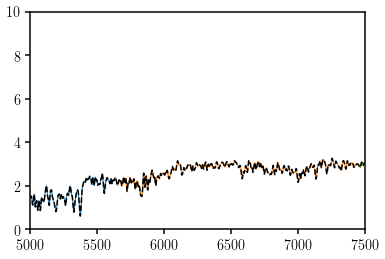

In [49]:
fig = plt.figure()
sub = fig.add_subplot(111)
for b in ['b', 'r', 'z']:
    sub.plot(specdata0.wave[b][::2], specdata0.flux[b].flatten()[::2], lw=1.)
sub.plot(BGSmaker.wave, flux0.flatten(), c='k', ls='--')
sub.set_xlim([5000., 7500])
sub.set_ylim([0., 10.])

In [29]:
simdata1 = simdata[0] 
simdata1['AIRMASS'] = 10.0
# Generate the observing conditions dictionary.  
obs1 = simdata2obsconditions(simdata1)    
specdata1 = simSpectra(BGSmaker.wave, flux0, 'bgs', obsconditions=obs1, 
                sourcetype='bgs', seed=sim1['seed'], expid=0)

DEBUG:simexp.py:405:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:409:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:431:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:435:simulate_spectra: obsconditions SEEING = 1.10000002384
DEBUG:simexp.py:435:simulate_spectra: obsconditions AIRMASS = 10.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONSEP = 180.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONALT = -60.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions EXPTIME = 300.0
DEBUG:simexp.py:659:get_source_types: bgs 1 targets
DEBUG:simexp.py:475:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:481:simulate_spectra: source types: 1 bgs


/Users/chang/anaconda2/lib/python2.7/site-packages/specsim-0.12.dev764-py2.7.egg/specsim/atmosphere.py:442: RuntimeWarning: invalid value encountered in arcsin
  np.sqrt((1 - self._airmass ** -2) / 0.96)) * u.rad


(0.0, 15.0)

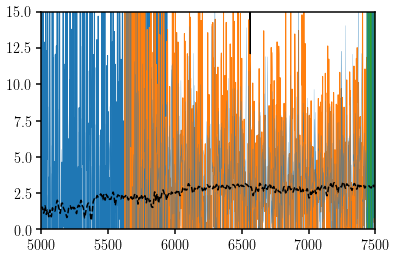

In [30]:
fig = plt.figure()
sub = fig.add_subplot(111)
for b in ['b', 'r', 'z']:
    sub.plot(specdata1.wave[b][::2], specdata1.flux[b].flatten()[::2], lw=1.)
    sub.plot(specdata0.wave[b][::2], specdata0.flux[b].flatten()[::2], lw=0.2, c='C0')
sub.plot(BGSmaker.wave, flux0.flatten(), c='k', ls='--')
sub.vlines(6562.801, 0., 100., linewidth=2, color='k')
sub.set_xlim([5000., 7500])
sub.set_ylim([0., 15.])

(-10.0, 15.0)

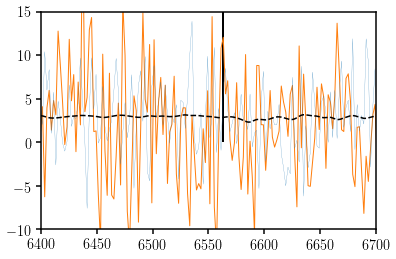

In [31]:
fig = plt.figure()
sub = fig.add_subplot(111)
for b in ['b', 'r', 'z']:
    sub.plot(specdata1.wave[b][::2], specdata1.flux[b].flatten()[::2], lw=1.)
    sub.plot(specdata0.wave[b][::2], specdata0.flux[b].flatten()[::2], lw=0.2, c='C0')
sub.plot(BGSmaker.wave, flux0.flatten(), c='k', ls='--')
sub.vlines(6562.801, 0., 100., linewidth=2, color='k')
sub.set_xlim([6400., 6700])
sub.set_ylim([-10., 15.])

In [32]:
simdata2 = simdata[0] 
simdata2['EXPTIME'] = 3000
# Generate the observing conditions dictionary.  
obs2 = simdata2obsconditions(simdata2)    
specdata2 = simSpectra(BGSmaker.wave, flux0, 'bgs', obsconditions=obs2, 
                sourcetype='bgs', seed=sim1['seed'], expid=0)

DEBUG:simexp.py:405:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:409:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:431:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:435:simulate_spectra: obsconditions SEEING = 1.10000002384
DEBUG:simexp.py:435:simulate_spectra: obsconditions AIRMASS = 10.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONSEP = 180.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONALT = -60.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions EXPTIME = 3000.0
DEBUG:simexp.py:659:get_source_types: bgs 1 targets
DEBUG:simexp.py:475:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:481:simulate_spectra: source types: 1 bgs


(-10.0, 15.0)

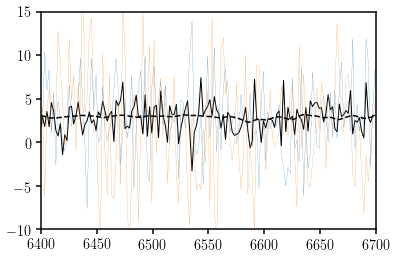

In [33]:
fig = plt.figure()
sub = fig.add_subplot(111)
for b in ['b', 'r', 'z']:
    sub.plot(specdata2.wave[b][::2], specdata2.flux[b].flatten()[::2], lw=1., c='k')
    sub.plot(specdata1.wave[b][::2], specdata1.flux[b].flatten()[::2], lw=0.2, c='C1')
    sub.plot(specdata0.wave[b][::2], specdata0.flux[b].flatten()[::2], lw=0.2, c='C0')
sub.plot(BGSmaker.wave, flux0.flatten(), c='k', ls='--')
sub.set_xlim([6400., 6700])
sub.set_ylim([-10., 15.])

In [34]:
obs3 = reference_conditions['DARK']
specdata3 = simSpectra(BGSmaker.wave, flux0, 'bgs', obsconditions=obs3, 
                sourcetype='bgs', seed=sim1['seed'], expid=0)

DEBUG:simexp.py:405:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:409:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:431:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:435:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:435:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:435:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:435:simulate_spectra: obsconditions EXPTIME = 1000
DEBUG:simexp.py:659:get_source_types: bgs 1 targets
DEBUG:simexp.py:475:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:481:simulate_spectra: source types: 1 bgs


(-10.0, 15.0)

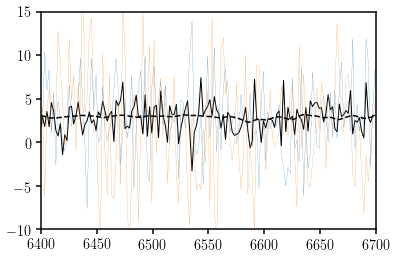

In [35]:
fig = plt.figure()
sub = fig.add_subplot(111)
for b in ['b', 'r', 'z']:
    sub.plot(specdata3.wave[b][::2], specdata2.flux[b].flatten()[::2], lw=1., c='k')
    sub.plot(specdata1.wave[b][::2], specdata1.flux[b].flatten()[::2], lw=0.2, c='C1')
    sub.plot(specdata0.wave[b][::2], specdata0.flux[b].flatten()[::2], lw=0.2, c='C0')
sub.plot(BGSmaker.wave, flux0.flatten(), c='k', ls='--')
sub.set_xlim([6400., 6700])
sub.set_ylim([-10., 15.])

In [46]:
simdata2

SEED,NSPEC,EXPTIME,AIRMASS,SEEING,MOONFRAC,MOONSEP,MOONALT
,,s,,arcsec,,deg,deg
str20,int32,float32,float32,float32,float32,float32,float32
11,100,3000.0,10.0,1.1,0.0,180.0,-60.0


In [38]:
tm = desitarget.targetmask.desi_mask

In [41]:
print tm.BGS_ANY

BGS_ANY          bit 60 mask 0x1000000000000000 - Any BGS bit is set


In [43]:
frame_fibermap = desispec.io.fibermap.empty_fibermap(1)

In [44]:
frame_fibermap

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR
str10,str20,str8,int64,int64,int64,int64,float32,str10,int64,int32,int32,int32,int32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
,,,0,0,0,0,0.0 .. 0.0,..,0,95,95,95,0,0,5400.0,0.0,0.0,0.0,0.0,-4.134643403129807,-176.01638919931523,-4.134643403129807,-176.01638919931523,0.0,0.0
